# Imports:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier as forest
from mpl_toolkits import mplot3d
from colorthief import ColorThief

# Task 0: Explore The Data and Cleaning

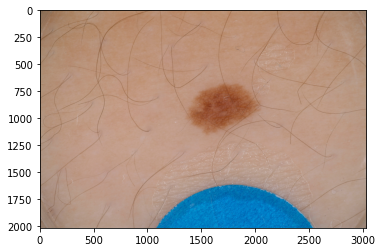

In [2]:
# Load in the image and the segmentation
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_image/'#something/somthingelse/fyp2021/data/example_image/'

the_image = "ISIC_0001769" # This is the image to be used in the rest of the code.

path=path+the_image+".jpg"
im = plt.imread(path)
plt.imshow(im)


path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_segmentation/'#something/somthingelse/fyp2021/data/example_image/'
path=path+the_image+'_segmentation.png' # Takes the_image name + _segmentation.png to get the right segmentation file.
imseg=plt.imread(path)

(2016, 3024, 3)
uint8


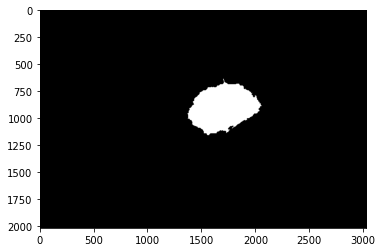

In [3]:
plt.imshow(imseg,cmap='gray')

# Shape and dimension of the image
print(im.shape)
print(im.dtype)

test = imseg[:,1500]

In [4]:
# # Finding maximum and minimum height and width of the lesion.
# heights=[]
# widths=[]
# # The range is chosen by visual inspection.
# for i in range(len(imseg)):
#     test=imseg[:,i]
#     test=list(test)
#     white1=test.count(1)
#     if white1!=0:
#         heights.append(white1)
# print('The max height is:',max(heights))
# print('The min height is:',min(heights))

# print()

# # The range is chosen by visual inspection.
# for i in range(len(imseg)):
#     test=imseg[i]
#     test=list(test)
#     white=test.count(1)
#     if white!=0:
#         widths.append(white)
# print('The max width is:',max(widths))
# print('The min width is:',min(widths)) 

## Cutting down the image to only the relevant area

In [5]:
minrow=-1
for i in imseg:
    minrow+=1
    if 1 in i:
        break
mincol=-1
for i in imseg.T:
    mincol+=1
    if 1 in i:
        break
height,width=imseg.shape
maxrow=-1
for i in np.flip(imseg,axis=0):
    maxrow+=1
    if 1 in i:
        break
maxcol=-1
for i in np.flip(imseg,axis=1).T:
    maxcol+=1
    if 1 in i:
        break
maxrow=height-maxrow-1
maxcol=width-maxcol-1
#cutting down the image segmentation
imseg=imseg[minrow:maxrow,mincol:maxcol]
#cutting down all the channels individually and stacking them to cut down image
red=im[minrow:maxrow,mincol:maxcol,0]
green=im[minrow:maxrow,mincol:maxcol,1]
blue=im[minrow:maxrow,mincol:maxcol,2]
im=np.dstack([red,green,blue])


path=os.getcwd() # Getting the image to use.
path=path[:-9]+'data/image_for_feature2/'
im_save = Image.fromarray(im)
im_save.save(path+"feature2_"+the_image+".jpg")

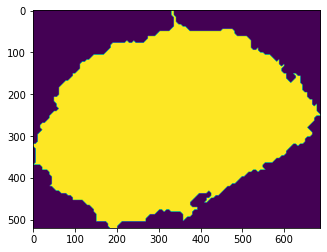

In [6]:
plt.imshow(imseg)

In [7]:
# Calculating the perimeter and the area of the lesion, taking the picture as an arrray.
def getoutline(imseg):
    minrow=-1
    for i in imseg:
        minrow+=1
        if 1 in i:
            break
    mincol=-1
    for i in imseg.T:
        mincol+=1
        if 1 in i:
            break
    height,width=imseg.shape
    maxrow=-1
    for i in np.flip(imseg,axis=0):
        maxrow+=1
        if 1 in i:
            break
    maxcol=-1
    for i in np.flip(imseg,axis=1).T:
        maxcol+=1
        if 1 in i:
            break
    maxrow=height-maxrow
    maxcol=width-maxcol
    #cutting down the image segmentation
    imseg=imseg[minrow:maxrow,mincol:maxcol]
    outline=[]
    row=0
    prev=0
    for i in imseg:
        column=0
        prev=0
        i=list(i)
        if 1 in i:
            for j in i:
                if j != prev and prev==0 and [row,column] not in outline:
                    outline.append([row,column])
                elif j!= prev and prev==1 and [row,column-1] not in outline:
                    outline.append([row,column-1])
                prev=j
                column+=1
        row+=1
    column=0
    for i in imseg.T:
        row=0
        prev=0
        i=list(i)
        if 1 in i:
            for j in i:
                # print(j)
                if j==1 and prev==0 and [row,column] not in outline:
                    outline.append([row,column])
                elif j==0 and prev==1 and [row-1,column] not in outline:
                    outline.append([row-1,column])
                prev=j
                row+=1
        column+=1
    return outline
outline=getoutline(imseg)
print('Perimeter is',len(outline),'pixels long')

print('The area is',sum(sum(imseg)),'pixels')



Perimeter is 1995 pixels long
The area is 216142.0 pixels


# Task 1: Implement Two Features

## Feature 1: Asymmetry

How this super awesome symmetry check works:

1) Split the outline of the shape in the middle assigning one or two middle columns depending on if the horizontal length is even or odd. Also assigns a middle row roughly.

2) Start with the leftmost column of pixels and get the distance to a fixed \[middlecol,middlerow] point, basically the centre, for each pixel in this column.

3) Sum all of these distances.

4) Then on the right side, it looks at which row the pixel in the left was in the related column, finds the nearest one here and calculates the distance to that same fixed point.

5) Then the result is given as the difference of both sums. Later on this value was divided by the area of the leison to attempt to scale with size of different images.

In [8]:
# Getting a symmetry value

def symcheck(outline):
    left={}
    right={}
    outlineset=set([x[0] for x in outline])#making a set with all column numbers in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbers in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    middlerow=round((maxrow+minrow)/2)
    #checking if the shape is even or odd, assigning a middle column based on that
    if (maxcol+mincol) % 2!=1:
        middlecol=int((maxcol+mincol)/2-0.5)
        for i in range(mincol,middlecol):#making dictinaries for both sides where entries are {column:[rows with pixels]}
            left[i]=[]
        for i in range(middlecol+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol:
                left[i[0]].append(i[1])
            elif i[0]>middlecol:
                right[i[0]].append(i[1])
        even=False
    else:#same thing but for even values of width
        middlecol=[int((maxcol+mincol)/2),int((maxcol+mincol)/2+1)]
        for i in range(mincol,middlecol[0]):
            left[i]=[]
        for i in range(middlecol[1]+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol[0]:
                left[i[0]].append(i[1])
            elif i[0]>middlecol[1]:
                right[i[0]].append(i[1])
        even=True
    counter=0
    leftcounter=mincol#setting the start values for both 
    rightcounter=maxcol
    leftdistance=0
    rightdistance=0
    prevclose=middlerow
    for i in range(len(left)):
        for j in left[leftcounter]:
            curlist=right[rightcounter]#finding corresponding list on the other side
            distancelist=[abs(x-j) for x in curlist]
            if distancelist==[]:    
                closest=prevclose
            else:
                closest=curlist[distancelist.index(min(distancelist))]#getting the closest pixel
            if even==True:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol[0])**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol[1])**2)+(abs(closest-middlerow)**2))
            else:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol)**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol)**2)+(abs(closest-middlerow)**2))
            prevclose=closest
        leftcounter+=1
        rightcounter-=1
    print('The vertical symmetry value for this shape is:',abs(rightdistance-leftdistance))
    return abs(rightdistance-leftdistance)

In [9]:
#diameter finding
def getdiameter(outline):
    outlineset=set([x[0] for x in outline])#making a set with all column numbers in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbers in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    possiblediameterpoints=[]
    for i in outline:
        if i[0]==mincol:
            possiblediameterpoints.append(i)
        if i[0]==maxcol:
            possiblediameterpoints.append(i)
        if i[1]==maxrow:
            possiblediameterpoints.append(i)
        if i[1]==minrow:
            possiblediameterpoints.append(i)
    maxdiameter=0
    for i in possiblediameterpoints:
        for j in possiblediameterpoints[1:]:
            diameter=math.sqrt(((i[0]-j[0])**2)+((i[1]-j[1])**2))
            if diameter>maxdiameter:
                maxdiameter=diameter
                pointsused=[i,j]
    centerofimage=[round(abs(pointsused[0][0]+pointsused[1][0])/2),round(abs(pointsused[0][1]+pointsused[1][1])/2)]
    return maxdiameter,pointsused,centerofimage



In [10]:
def rotate(outline):
    maxdiameter,pointsused,centerofimage=getdiameter(outline)
    widthoftri=abs(pointsused[0][0]-pointsused[1][0])
    heightoftri=abs(pointsused[0][1]-pointsused[1][1])
    case=0
    if widthoftri>=heightoftri:
        angle=math.asin(heightoftri/maxdiameter)
    elif widthoftri<=heightoftri:
        angle=math.asin(widthoftri/maxdiameter)
        case=1
    if case==1:
        angle=-angle
    cos=math.cos(angle)
    sin=math.sin(angle)
    newoutline=[]
    for i in outline:
        x=i[0]
        y=i[1]
        new_x=round((x*cos+y*sin)+widthoftri)
        new_y=round((-x*sin+y*cos)+heightoftri)
        newoutline.append([new_x,new_y])
    return newoutline

## Feature 2:

We have choosen to use the mean of the blue spectrum of the lesion as the second feature based on some research we found online about classification of color features in skin lesions.
In their reseach they conclude amonst other features, that the mean of the red and blue channel is the best features to determine melanoma.

Link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184884/

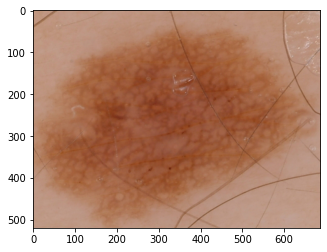

In [11]:
plt.imshow(im)

In [12]:

def mean_value(imagename):
    path=os.getcwd() # Getting the image to use.
    path=path[:-9]+'data/example_image/'
    path=path+str(imagename)+'.jpg'
    image=plt.imread(path)

    path=os.getcwd() # Getting the image segmentation to use.
    path=path[:-9]+'data/example_segmentation/'
    path=path+str(imagename)+'_segmentation.png'
    imseg=plt.imread(path)
    
    boolean_imseg = imseg == 1 # Masks the picture with the segmentation.

    red = image[boolean_imseg][:,0] # Masks the picture with the segmentation in the red channel.
    green = image[boolean_imseg][:,1] # Masks the picture with the segmentation in the green channel.
    blue = image[boolean_imseg][:,2] # Masks the picture with the segmentation in the blue channel.

    red_mean = np.mean(red)
    blue_mean = np.mean(blue)

    return blue_mean

print(mean_value("ISIC_0001769"))


# fig,ax = plt.subplots(1,3,figsize=(26,8))
# ax[0].hist(red,bins=255,color='red')
# ax[0].set_title('Red')
# ax[1].hist(green,bins=255,color='green')
# ax[1].set_title("Green")
# ax[2].hist(blue,bins=255,color='blue')
# ax[2].set_title("Blue");

67.78621391561806


In [111]:
#def lesion_only_TEST(im,imseg,imagename):
#
#    path=os.getcwd() # Getting the image to use.
#    path=path[:-9]+'data/image_for_feature2/'+"feature2_"+ imagename + ".jpg"
#    
#    color_thief = ColorThief(path)
#    dominant_color = color_thief.get_color(quality = 1)
#    print(dominant_color)
#    range_ = 0.1
#    r_lower = abs(dominant_color[0] - dominant_color[0]* range_)
#    r_upper = abs(dominant_color[0] + dominant_color[0]* range_)
#    g_lower = abs(dominant_color[1] - dominant_color[1]* range_)
#    g_upper = abs(dominant_color[1] + dominant_color[1]* range_)
#    b_lower = abs(dominant_color[2] - dominant_color[2]* range_)
#    b_upper = abs(dominant_color[2] + dominant_color[2]* range_)
#
#    counter_ = 0
#    row_ = -1
#    old_row = row_
#    column_ = -1
#    for i in imseg: # Goes trough the whole lesion and checks for colorrange.
#        row_ = row_ + 1
#        for j in i:
#            column_ = column_ + 1
#            if row_ > old_row:
#                column_ = 0
#            old_row = row_
#            if j == 1: # Checking if the pixel is within the lesion area, and then checks if each RGB value is within the range.
#                if r_lower < im[row_][column_][0] < r_upper and g_lower < im[row_][column_][1] < g_upper and b_lower < im[row_][column_][2] < b_upper:
#                    im[row_][column_][0] = 1
#                    im[row_][column_][1] = 1
#                    im[row_][column_][2] = 1
#                    counter_ = counter_ + 1
#    
#    area_ = sum(sum(imseg))
#    print('Counter:',counter_)
#    print("The area is",area_,"pixels")
#    print("Procentage:",counter_/area_)
#    return im


#lesion_only_TEST(im,imseg,"ISIC_0015372")

#plt.imshow(im)

# Task 2: Predict The Diagnosis

### Splitting data into training and test data

In [14]:
#This is the loop that we had used to get all the image symmetry values
# symvalues=[]
# areas=[]
# for i in trainingimagearray:
    # path=os.getcwd()
    # path=path[:-9]+'data/example_segmentation/'
    # path=path+str(i)+'_segmentation.png'
    # imseg=plt.imread(path)
    # symvalues.append(symcheck(rotateacrossdiameter(getoutline(imseg),imseg)))


In [15]:
#loading in all the relevant data
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/'
path=path+'example_ground_truth.csv'
alldata=pd.read_csv(path)

path=os.getcwd()
path=path[:-9]+'features/expandedfeatures.csv'
expandedfeatures=pd.read_csv(path)

path=os.getcwd()
path=path[:-9]+'features/normalizedfeatures.csv'
normalizedfeatures=pd.read_csv(path)

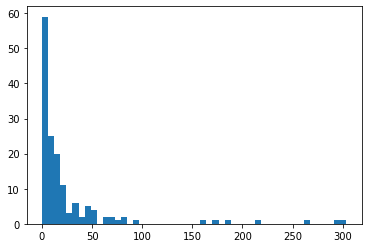

In [16]:
plt.hist(expandedfeatures['scaledsym'],bins=50);

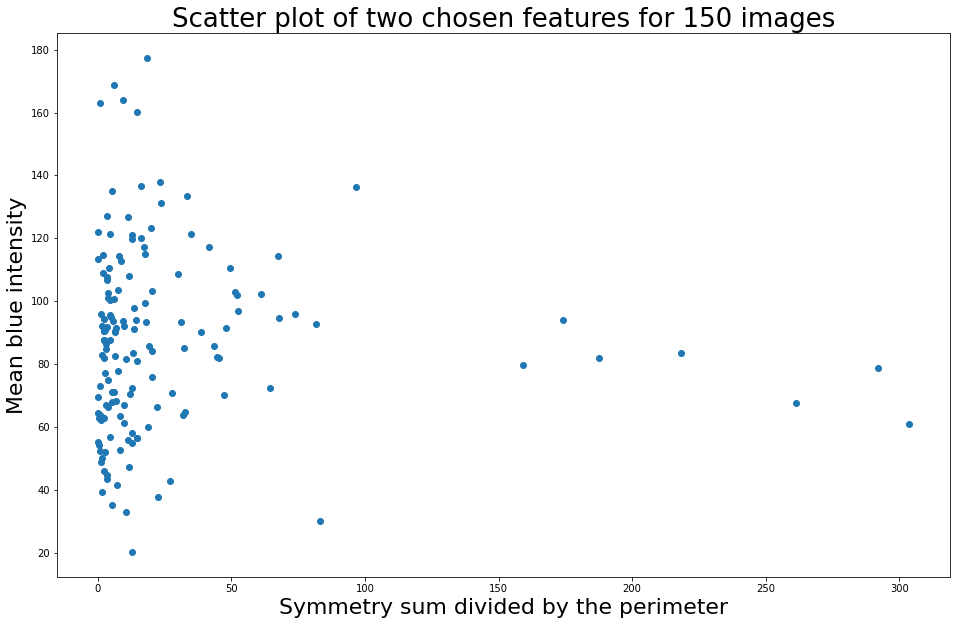

In [17]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(16,10))
ax.scatter(expandedfeatures['scaledsym'],expandedfeatures['meanblue']);
ax.set_ylabel('Mean blue intensity',size=22)
ax.set_xlabel('Symmetry sum divided by the perimeter',size=22)
ax.set_title('Scatter plot of two chosen features for 150 images',size=26);

In [18]:
# #saving the expanded features after adding a feature
# path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
# path=path[:-9]+'features/'
# path=path+'expandedfeatures.csv'
# expandedfeatures.to_csv(path,index=False)

In [19]:
#normalizing the data by taking away the mean and dividing by the standard devitation 
# normalizedfeatures=expandedfeatures['image_id']
# counter=0
# for i in expandedfeatures:
#     if counter==0:
#         counter+=1
#         pass
#     else:
#         newcol=[]
#         finalcol=[]
#         for j in expandedfeatures[i]:
#             newcol.append(j)
#         newcol=pd.DataFrame(newcol)
#         mean=newcol.mean()
#         deviaton=newcol.std()
#         for k in newcol[0]:
#             finalcol.append((k-mean)/deviaton)
#         finalcol=pd.DataFrame(finalcol)
#         normalizedfeatures=pd.concat([normalizedfeatures,finalcol],axis=1)
# normalizedfeatures.columns=expandedfeatures.columns
# path=os.getcwd()
# path=path[:-9]+'features/normalizedfeatures.csv'
# normalizedfeatures.to_csv(path,index=False)

In [20]:
#oversampling attempt
melanomafeatures=normalizedfeatures.loc[alldata['melanoma']==1]
oversampledfeatures=pd.concat([normalizedfeatures,melanomafeatures,melanomafeatures,melanomafeatures])
melanomadata=alldata.loc[alldata['melanoma']==1]
oversampleddata=pd.concat([alldata,melanomadata,melanomadata,melanomadata])

In [21]:
combinationsof2=[]
for i in normalizedfeatures.columns[1:]:
    for j in normalizedfeatures.columns[2:]:
        if [j,i] not in combinationsof2 and i!=j:
            combinationsof2.append([i,j])
combinationsof2

[['symsums', 'area'],
 ['symsums', 'perimeter'],
 ['symsums', 'meanblue'],
 ['symsums', 'scaledsym'],
 ['area', 'perimeter'],
 ['area', 'meanblue'],
 ['area', 'scaledsym'],
 ['perimeter', 'meanblue'],
 ['perimeter', 'scaledsym'],
 ['meanblue', 'scaledsym']]

In [22]:
#oversampled data
for i in combinationsof2:
    acc=0
    auc=0
    sensitivity=0
    specificity=0
    for l in range(100):
        neigh=knn(n_neighbors=5)
        X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[i],oversampleddata['melanoma'],train_size=0.70)
        neigh.fit(X_train,y_train)
        yval=neigh.predict(X_test)
        acc=acc+accuracy_score(y_test,yval)
        tp=0
        fn=0
        fp=0
        tn=0
        for j,k in zip(y_test,yval):
            if j==k and j==1:
                tp+=1
            if j==1 and k==0:
                fn+=1
            if j==k and j==0:
                tn+=1
            if j==0 and k==1:
                fp+=1
        sensitivity=sensitivity+tp/(tp+fn)
        specificity=specificity+tn/(tn+fp)
        auc = auc + roc_auc_score(y_test,yval)
    print('The combination of these:',i,'had an accuracy score of:',acc/100)
    print('The sensitivity of this combination is:',sensitivity/100)
    print('The specificity of this model is:',specificity/100)
    print('The auc value is:',auc/100,'\n')

The combination of these: ['symsums', 'area'] had an accuracy score of: 0.6143055555555555
The sensitivity of this combination is: 0.7077266200051195
The specificity of this model is: 0.5240050132580819
The auc value is: 0.6158658166316008 

The combination of these: ['symsums', 'perimeter'] had an accuracy score of: 0.7149999999999999
The sensitivity of this combination is: 0.8233374078543706
The specificity of this model is: 0.6113963578418999
The auc value is: 0.717366882848135 

The combination of these: ['symsums', 'meanblue'] had an accuracy score of: 0.6579166666666666
The sensitivity of this combination is: 0.7835186062850219
The specificity of this model is: 0.5412533418926693
The auc value is: 0.6623859740888456 

The combination of these: ['symsums', 'scaledsym'] had an accuracy score of: 0.6805555555555556
The sensitivity of this combination is: 0.7571968857435022
The specificity of this model is: 0.6133206087424866
The auc value is: 0.6852587472429945 

The combination of 

The accuracy accuracy score was: 0.7111111111111111
The sensitivity of this combination is: 0.0
The specificity of this model is: 0.9411764705882353
The auc value is: 0.47058823529411764
tp: 0 tn: 32 fp: 2 fn: 11


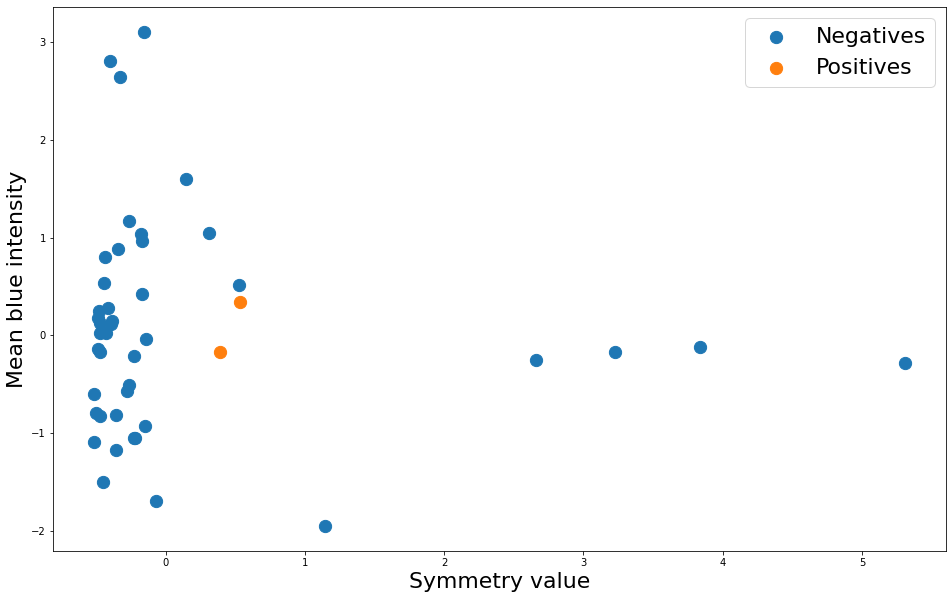

In [112]:
neigh1=knn(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(normalizedfeatures[['scaledsym','meanblue']],alldata['melanoma'],train_size=0.70,random_state=1337)
neigh1.fit(X_train,y_train)
yval=neigh1.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_test=X_test.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_test['scaledsym'],X_test['meanblue'],predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(16,10))
ax.set_ylabel('Mean blue intensity',fontsize=22)
ax.set_xlabel('Symmetry value',fontsize=22)
ax.scatter(negatives['scaledsym'],negatives['meanblue'],label='Negatives',s=150);
ax.scatter(positives['scaledsym'],positives['meanblue'],label='Positives',s=150);
ax.legend(fontsize=22);

In [24]:
sum(y_test)

11.0

In [25]:
neigh2=knn(n_neighbors=15)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
neigh2.fit(X_train,y_train)
yval=neigh2.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_test=X_test.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_test['scaledsym'],X_test['meanblue'],predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
# fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(16,10))
# ax.scatter(negatives['scaledsym'],negatives['meanblue']);
# ax.scatter(positives['scaledsym'],positives['meanblue']);

The accuracy accuracy score was: 0.6805555555555556
The sensitivity of this combination is: 0.7272727272727273
The specificity of this model is: 0.6410256410256411
The auc value is: 0.6841491841491841
tp: 24 tn: 25 fp: 14 fn: 9


In [26]:
neigh5=knn(n_neighbors=15)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
neigh5.fit(X_train,y_train)
yval=neigh5.predict(X_train)
acc=accuracy_score(y_train,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_train,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_train,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)

The accuracy accuracy score was: 0.6845238095238095
The sensitivity of this combination is: 0.735632183908046
The specificity of this model is: 0.6296296296296297
The auc value is: 0.6826309067688379
tp: 64 tn: 51 fp: 30 fn: 23


The accuracy accuracy score was: 0.7333333333333333
The sensitivity of this combination is: 0.2727272727272727
The specificity of this model is: 0.8823529411764706
The auc value is: 0.5775401069518716
tp: 3 tn: 30 fp: 4 fn: 8


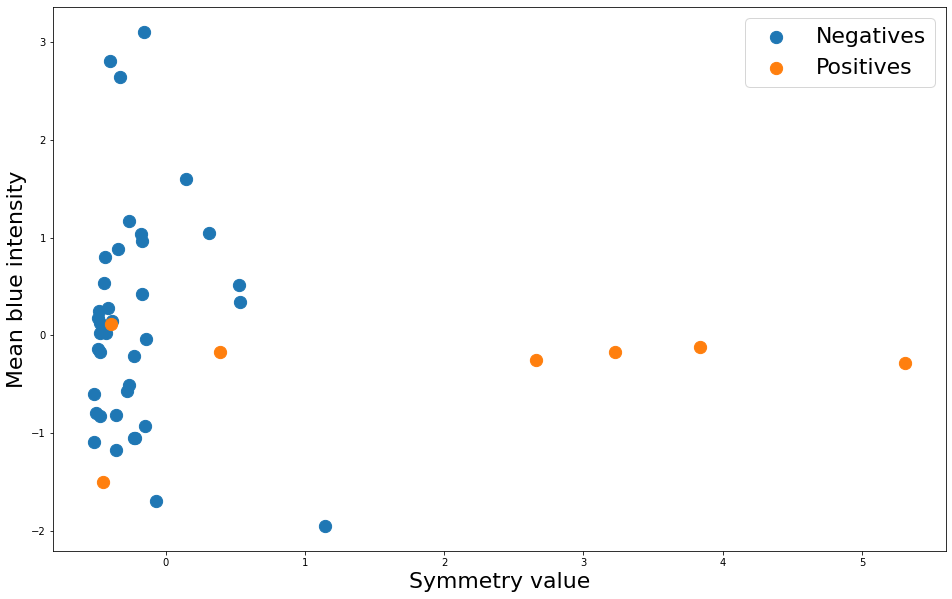

In [109]:
forestmodel1=forest(random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(normalizedfeatures[['scaledsym','meanblue']],alldata['melanoma'],train_size=0.70,random_state=1337)
forestmodel1.fit(X_train,y_train)
yval=forestmodel1.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_test=X_test.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_test['scaledsym'],X_test['meanblue'],predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(16,10))
ax.set_ylabel('Mean blue intensity',fontsize=22)
ax.set_xlabel('Symmetry value',fontsize=22)
ax.scatter(negatives['scaledsym'],negatives['meanblue'],label='Negatives',s=150);
ax.scatter(positives['scaledsym'],positives['meanblue'],label='Positives',s=150);
ax.legend(fontsize=22)

The accuracy accuracy score was: 0.6944444444444444
The sensitivity of this combination is: 0.7272727272727273
The specificity of this model is: 0.6666666666666666
The auc value is: 0.696969696969697
tp: 24 tn: 26 fp: 13 fn: 9


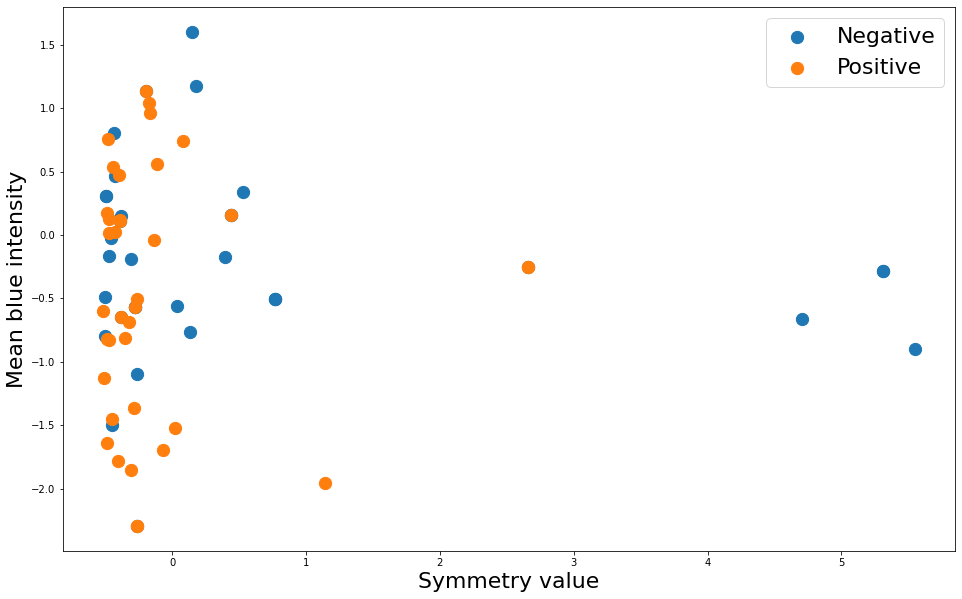

In [110]:
forestmodel2=forest(random_state=1337,max_depth=2,max_leaf_nodes=3)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
forestmodel2.fit(X_train,y_train)
yval=forestmodel2.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_train=X_train.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_train['scaledsym'],X_train['meanblue'],predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(16,10))
ax.set_ylabel('Mean blue intensity',fontsize=22)
ax.set_xlabel('Symmetry value',fontsize=22)
ax.scatter(negatives['scaledsym'],negatives['meanblue'], label = "Negative", s = 150);
ax.scatter(positives['scaledsym'],positives['meanblue'], label = "Positive", s = 150);
ax.legend(fontsize = 22)


In [29]:
forestmodeloverfit=forest(random_state=1337,max_depth=2,max_leaf_nodes=3)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
forestmodeloverfit.fit(X_train,y_train)
yval=forestmodeloverfit.predict(X_train)
acc=accuracy_score(y_train,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_train,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_train,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)

The accuracy accuracy score was: 0.7440476190476191
The sensitivity of this combination is: 0.735632183908046
The specificity of this model is: 0.7530864197530864
The auc value is: 0.7443593018305662
tp: 64 tn: 61 fp: 20 fn: 23


In [30]:
#adding noise
noise = np.random.RandomState(55).uniform(0, 0.1, size=(normalizedfeatures.shape[0], 20))
X = np.hstack((normalizedfeatures[['symsums','area', 'perimeter','meanblue','scaledsym']], noise))
Y=alldata['melanoma']

<BarContainer object of 25 artists>

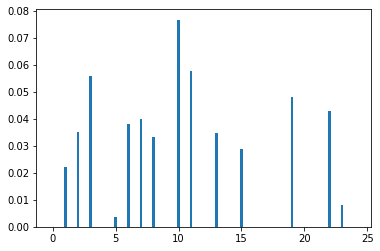

In [31]:
X_dev, X_test, y_dev, y_test = train_test_split(
        X, Y, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

plt.bar(np.arange(0,25), scores, width=.2,
        label=r'Feature score')

# Task 3 open question

How does the addition of a third feature change the performance of the models?

The accuracy accuracy score was: 0.6944444444444444
The sensitivity of this combination is: 0.7272727272727273
The specificity of this model is: 0.6666666666666666
The auc value is: 0.696969696969697
tp: 24 tn: 26 fp: 13 fn: 9


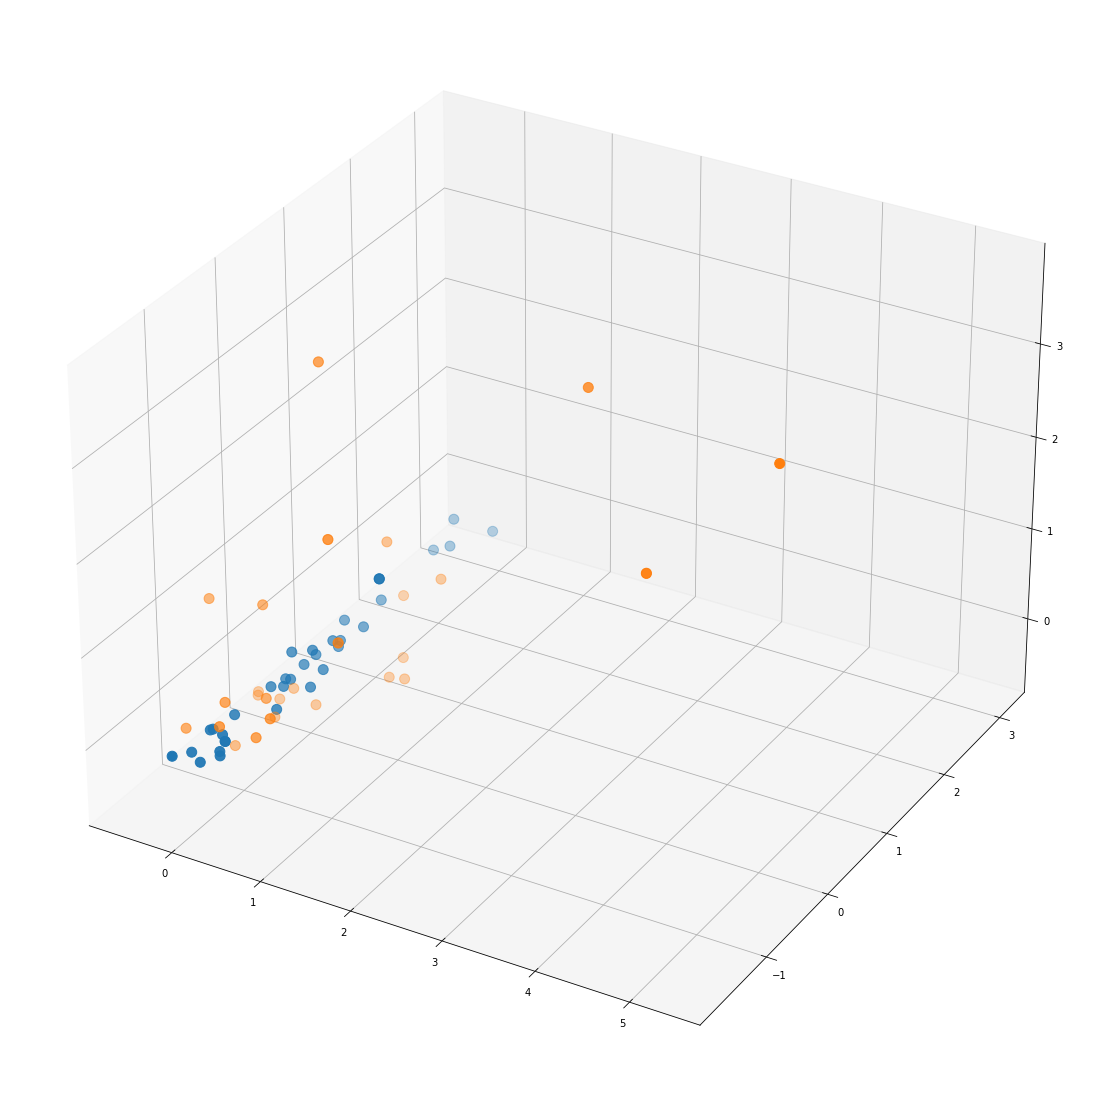

In [32]:
neigh3=knn(n_neighbors=15)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue','area']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
neigh3.fit(X_train,y_train)
yval=neigh3.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_test=X_test.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_test,predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
fig=plt.figure(figsize=(20,20))
ax=plt.axes(projection='3d')
ax.scatter3D(negatives['scaledsym'],negatives['meanblue'],negatives['area'],s=100)
ax.scatter3D(positives['scaledsym'],positives['meanblue'],positives['area'],s=100)

The accuracy accuracy score was: 0.7083333333333334
The sensitivity of this combination is: 0.8181818181818182
The specificity of this model is: 0.6153846153846154
The auc value is: 0.7167832167832169
tp: 27 tn: 24 fp: 15 fn: 6


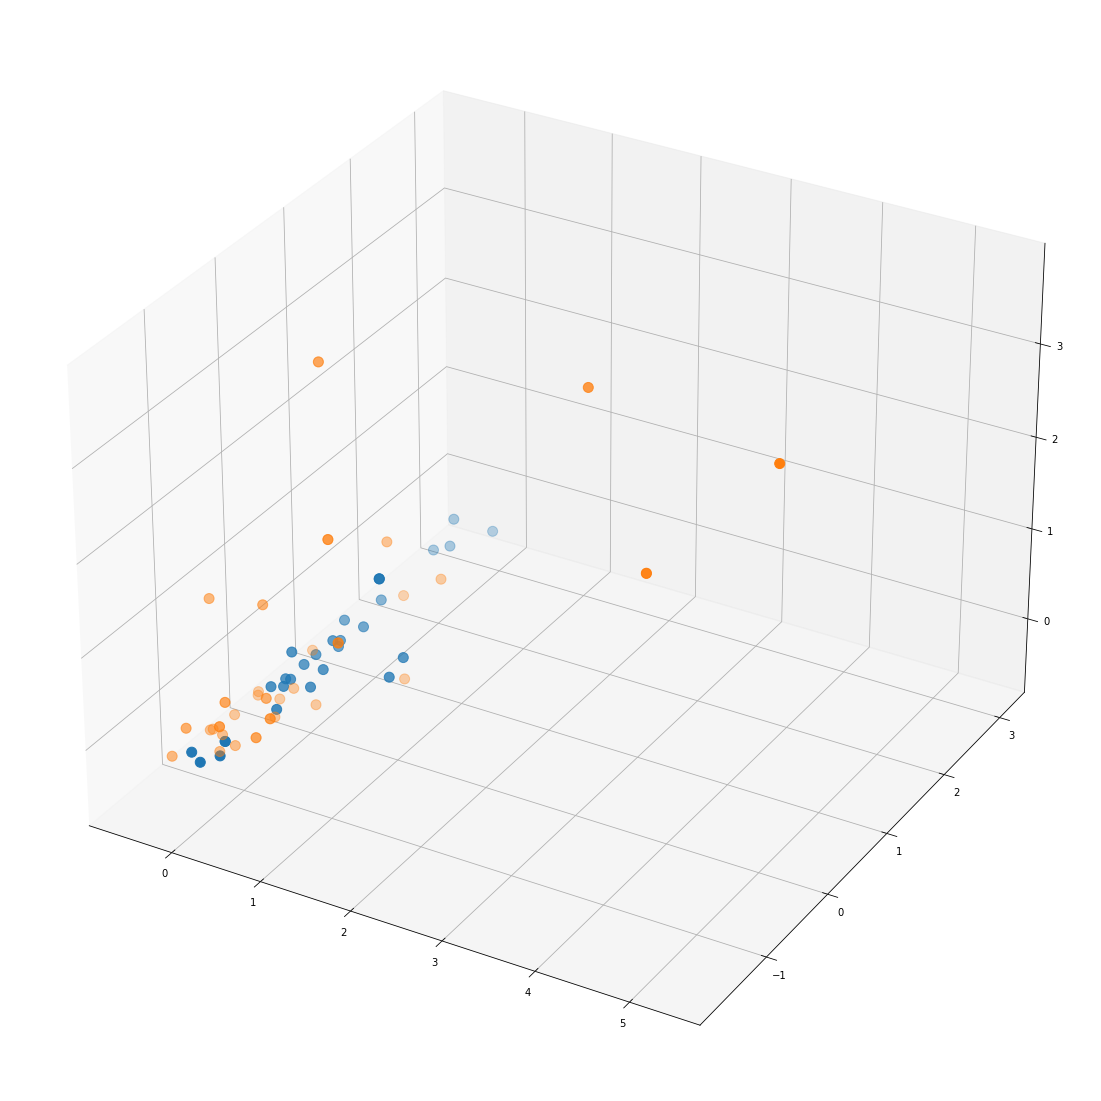

In [33]:
forestmodel2=forest(random_state=1337,max_depth=3,max_leaf_nodes=4)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue','area']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
forestmodel2.fit(X_train,y_train)
yval=forestmodel2.predict(X_test)
acc=accuracy_score(y_test,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_test,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_test,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)
X_test=X_test.reset_index(drop=True)
predicted=pd.DataFrame(yval)
scatterpredicted=pd.concat([X_test,predicted],axis=1)
positives=scatterpredicted.loc[scatterpredicted[0]==1]
negatives=scatterpredicted.loc[scatterpredicted[0]==0]
fig=plt.figure(figsize=(20,20))
ax=plt.axes(projection='3d')
ax.scatter3D(negatives['scaledsym'],negatives['meanblue'],negatives['area'],s=100)
ax.scatter3D(positives['scaledsym'],positives['meanblue'],positives['area'],s=100)

In [34]:
#overfitting test
forestmodeloverfit=forest(random_state=1337,max_depth=3,max_leaf_nodes=2)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue','area']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
forestmodeloverfit.fit(X_train,y_train)
yval=forestmodeloverfit.predict(X_train)
acc=accuracy_score(y_train,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_train,yval):
    # print(j,k)
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_train,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)

The accuracy accuracy score was: 0.7440476190476191
The sensitivity of this combination is: 0.8045977011494253
The specificity of this model is: 0.6790123456790124
The auc value is: 0.7418050234142188
tp: 70 tn: 55 fp: 26 fn: 17


In [35]:
neigh4=knn(n_neighbors=15)
X_train, X_test, y_train, y_test = train_test_split(oversampledfeatures[['scaledsym','meanblue','area']],oversampleddata['melanoma'],train_size=0.70,random_state=1337)
neigh4.fit(X_train,y_train)
yval=neigh4.predict(X_train)
acc=accuracy_score(y_train,yval)
tp=0
fn=0
fp=0
tn=0
for j,k in zip(y_train,yval):
    if j==k and j==1:
        tp+=1
    if j==1 and k==0:
        fn+=1
    if j==k and j==0:
        tn+=1
    if j==0 and k==1:
        fp+=1
sensitivity=tp/(tp+fn)
specificity=tn/(tn+fp)
auc =roc_auc_score(y_train,yval)
print('The accuracy accuracy score was:',acc)
print('The sensitivity of this combination is:',sensitivity)
print('The specificity of this model is:',specificity)
print('The auc value is:',auc)
print('tp:',tp,'tn:',tn,'fp:',fp,'fn:',fn)

The accuracy accuracy score was: 0.7202380952380952
The sensitivity of this combination is: 0.735632183908046
The specificity of this model is: 0.7037037037037037
The auc value is: 0.7196679438058748
tp: 64 tn: 57 fp: 24 fn: 23


In [36]:
#adding noise
noise = np.random.RandomState(55).uniform(0, 0.1, size=(oversampledfeatures.shape[0], 20))
X = np.hstack((oversampledfeatures[['scaledsym','meanblue','area']], noise))
Y=oversampleddata['melanoma']

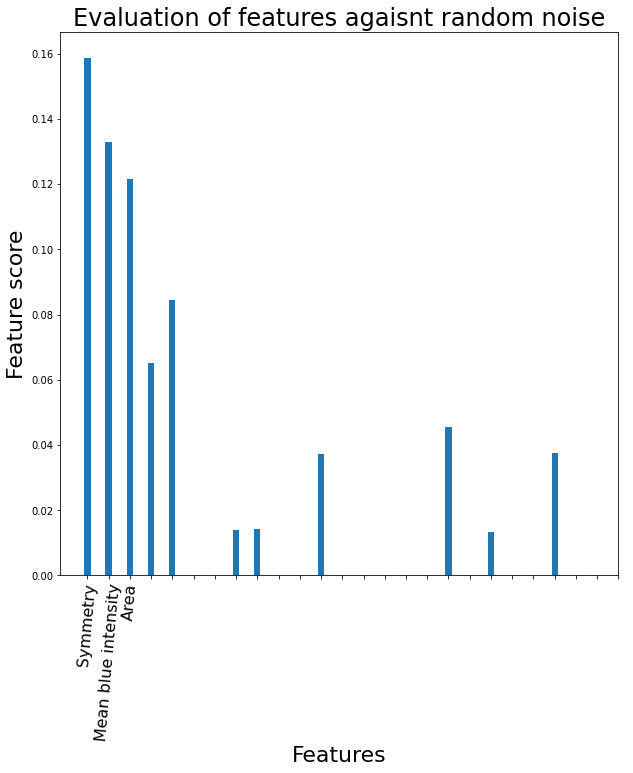

In [79]:
X_dev, X_test, y_dev, y_test = train_test_split(
        X, Y, stratify=Y,random_state=8008)
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev,random_state=746498) # 13372143    936585    746498
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)
noiselabels=[' ' for x in range(23)]
labels=['Symmetry','Mean blue intensity','Area']+noiselabels
ticks=[i for i in range(len(labels))]
scores = selector.scores_
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(0,23), scores, width=.3)
ax.set_ylabel('Feature score',size=22)
ax.set_xticks(ticks);
ax.set_xticklabels(labels,rotation=85,fontsize=16);
ax.set_xlabel('Features',size=22)
ax.set_title('Evaluation of features agaisnt random noise',size=24);
plt.savefig("Task_3_barplot_3.png")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c01f5965-259c-4c17-ae6d-879577586d70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>